In [21]:
def stepwise_selection(X, y,
					   initial_list=[],
					   threshold_in=0.05,
					   threshold_out=0.10,
					   verbose=True):
	"""
	Perform a stepwise feature selection based on p-values from statsmodels OLS.

	Parameters:
	- X : pd.DataFrame
		Candidate feature set (independent variables).
	- y : pd.Series or np.array
		Target variable (dependent variable).
	- initial_list : list
		Initial list of features to start the selection process.
	- threshold_in : float
		p-value threshold for adding a feature (smaller = more strict).
	- threshold_out : float
		p-value threshold for removing a feature (larger = more lenient).
	- verbose : bool
		Whether to print progress during feature selection.

	Returns:
	- included : list
		The final list of selected features.
	"""

	included = list(initial_list)  # Start with an initial list (could be empty)

	while True:
		changed = False  # Flag to track whether any feature was added or removed in the current iteration; If not, the loop will break

		# --- Forward Step ---
		# Try adding each feature not yet included and check p-values
		excluded = list(set(X.columns) - set(included))  # Compute the list of features not yet included in the model; These are the candidates for addition
		new_pval = pd.Series(index=excluded, dtype=float)  # Initialise a Series to store the p-values of each excluded feature if it were to be added to the model
		for new_column in excluded: # Iterate over all excluded features to assess their contribution
			# Fit OLS model with the current included features + this new one
			X_with_const = sm.add_constant(X[included + [new_column]]) # Prepare the design matrix with a constant term (intercept) and the current included features plus the candidate new feature
			model = sm.OLS(y, X_with_const).fit() # Fits an Ordinary Least Squares (OLS) linear regression model to the current design matrix
			new_pval[new_column] = model.pvalues[new_column]  # Extract the p-value of the newly added feature and stores it

		# Add the feature with the lowest p-value if it's below threshold_in
		if not new_pval.empty and new_pval.min() < threshold_in: # Check whether the smallest p-value among the excluded features is statistically significant, i.e., below the inclusion threshold
			best_pval = new_pval.idxmin()  # Feature with the smallest p-value
			included.append(best_pval)
			changed = True
			if verbose:
				print(f'Add {best_pval} with p-value {new_pval.min():.6f}')

		# --- Backward Step ---
		# Now check if any included feature should be removed
		X_with_const = sm.add_constant(X[included])
		model = sm.OLS(y, X_with_const).fit() # Re-fit the model using the current set of included features to re-calculate all p-values
		pvalues = model.pvalues.iloc[1:]  # Get p-values for all features excluding the intercept (which is the first value); These are the features being evaluated for possible removal

		# If any included feature has a p-value above threshold_out, remove the worst one
		if not pvalues.empty and pvalues.max() > threshold_out: # If the worst (largest) p-value among included features exceeds the exclusion threshold, it’s a candidate for removal
			worst_pval = pvalues.idxmax() # Find the feature with the worst (largest) p-value
			included.remove(worst_pval) # Remove this feature from the model
			changed = True
			if verbose:
				print(f'Drop {worst_pval} with p-value {pvalues.max():.6f}')

		# If no feature was added or removed, the process is done
		if not changed:
			break

	# Print final selected features and summary
	if verbose:
		print("\nFinal Selected Variables:")
		print(included)
		final_X_with_const = sm.add_constant(X[included])
		final_model = sm.OLS(y, final_X_with_const).fit()
		print("\nFinal Model Summary:")
		print(final_model.summary())

	return included

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [96]:
dir(sklearn.model_selection)

NameError: name 'sklearn' is not defined

In [ ]:
ocean_data

TypeError: 'Index' object is not callable

In [118]:
# 분류 
ocean_data = pd.read_csv('data/rate_ocean_final.csv')

ocean_data.set_index('Date',inplace=True)

# ocean_data=ocean_data[col]

In [99]:
col=['가자미류', '청어', '새우', '대구', '도루묵', '기타어류', '총어획량 ', '금지여부','염분_50m','염분_100m', '염분_200m', '염분_300m', '염분_400m', '염분_500m', '해저수온_100m','해저수온_200m', '해저수온_300m', '해저수온_400m', '해저수온_500m','mean_해수면높이','평균 풍속(m/s)', '평균기압(hPa)', '평균 상대습도(%)', '평균 기온(°C)', '평균 최대 파고(m)','평균 파주기(sec)']

In [103]:
ocean_data

,가자미류,청어,새우,대구,도루묵,기타어류,총어획량,금지여부,염분_50m,염분_100m,...,해저수온_300m,해저수온_400m,해저수온_500m,mean_해수면높이,평균 풍속(m/s),평균기압(hPa),평균 상대습도(%),평균 기온(°C),평균 최대 파고(m),평균 파주기(sec)
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-05,62.7,7.6,6.8,4.1,3.2,15.6,37872.0,0,34.087777,34.056530,...,2.618654,1.170916,0.867136,0.071283,5.420000,1018.220000,60.000000,4.100000,2.360000,3.680000
2011-03-12,48.5,1.6,3.4,2.4,37.8,6.3,79934.0,0,34.115109,34.077639,...,2.705634,1.205661,0.873943,0.069657,6.785714,1017.542857,53.142857,6.257143,1.957143,2.828571
2011-03-19,69.8,7.0,5.0,2.5,5.6,10.1,64910.0,0,34.147962,34.108084,...,2.605231,1.209041,0.862841,0.065963,6.771429,1017.828571,68.000000,7.457143,2.442857,3.371429
2011-03-26,75.1,0.5,5.0,2.6,6.4,10.4,53873.0,0,34.173486,34.129434,...,2.346879,1.180908,0.810952,0.055197,6.600000,1019.700000,64.000000,6.042857,2.257143,2.971429
2011-04-02,80.0,0.0,4.9,5.0,0.8,9.3,86681.0,0,34.210325,34.145569,...,2.045112,1.085696,0.740865,0.050113,5.171429,1021.400000,64.000000,9.100000,1.357143,2.728571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-04,55.5,1.3,29.1,8.7,0.7,4.7,80427.0,0,33.642911,33.844457,...,1.013735,0.480097,0.290103,0.305960,9.400000,1020.485714,62.142857,7.742857,2.600000,5.028571
2025-01-11,55.0,2.5,27.2,9.0,0.5,5.8,57854.0,0,33.724002,33.837401,...,1.023831,0.502683,0.285548,0.290507,9.400000,1018.514286,59.000000,4.685714,4.000000,5.785714
2025-01-18,51.6,7.4,30.8,3.5,0.6,6.1,86373.0,0,33.768318,33.842817,...,1.058974,0.518791,0.281510,0.239657,9.400000,1021.900000,59.000000,7.042857,2.700000,4.914286


In [104]:
data_col = ocean_data.iloc[:,:6].columns.tolist()

In [105]:
for i in data_col:
    ocean_data[i]= ocean_data[i]*0.01

In [106]:
ocean_data

,가자미류,청어,새우,대구,도루묵,기타어류,총어획량,금지여부,염분_50m,염분_100m,...,해저수온_300m,해저수온_400m,해저수온_500m,mean_해수면높이,평균 풍속(m/s),평균기압(hPa),평균 상대습도(%),평균 기온(°C),평균 최대 파고(m),평균 파주기(sec)
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-05,0.627,0.076,0.068,0.041,0.032,0.156,37872.0,0,34.087777,34.056530,...,2.618654,1.170916,0.867136,0.071283,5.420000,1018.220000,60.000000,4.100000,2.360000,3.680000
2011-03-12,0.485,0.016,0.034,0.024,0.378,0.063,79934.0,0,34.115109,34.077639,...,2.705634,1.205661,0.873943,0.069657,6.785714,1017.542857,53.142857,6.257143,1.957143,2.828571
2011-03-19,0.698,0.070,0.050,0.025,0.056,0.101,64910.0,0,34.147962,34.108084,...,2.605231,1.209041,0.862841,0.065963,6.771429,1017.828571,68.000000,7.457143,2.442857,3.371429
2011-03-26,0.751,0.005,0.050,0.026,0.064,0.104,53873.0,0,34.173486,34.129434,...,2.346879,1.180908,0.810952,0.055197,6.600000,1019.700000,64.000000,6.042857,2.257143,2.971429
2011-04-02,0.800,0.000,0.049,0.050,0.008,0.093,86681.0,0,34.210325,34.145569,...,2.045112,1.085696,0.740865,0.050113,5.171429,1021.400000,64.000000,9.100000,1.357143,2.728571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-04,0.555,0.013,0.291,0.087,0.007,0.047,80427.0,0,33.642911,33.844457,...,1.013735,0.480097,0.290103,0.305960,9.400000,1020.485714,62.142857,7.742857,2.600000,5.028571
2025-01-11,0.550,0.025,0.272,0.090,0.005,0.058,57854.0,0,33.724002,33.837401,...,1.023831,0.502683,0.285548,0.290507,9.400000,1018.514286,59.000000,4.685714,4.000000,5.785714
2025-01-18,0.516,0.074,0.308,0.035,0.006,0.061,86373.0,0,33.768318,33.842817,...,1.058974,0.518791,0.281510,0.239657,9.400000,1021.900000,59.000000,7.042857,2.700000,4.914286


In [108]:
X = ocean_data.drop(['총어획량 '],axis=1)
y = ocean_data['총어획량 ']
X.columns

Index(['가자미류', '청어', '새우', '대구', '도루묵', '기타어류', '금지여부', '염분_50m', '염분_100m',
       '염분_200m', '염분_300m', '염분_400m', '염분_500m', '해저수온_100m', '해저수온_200m',
       '해저수온_300m', '해저수온_400m', '해저수온_500m', 'mean_해수면높이', '평균 풍속(m/s)',
       '평균기압(hPa)', '평균 상대습도(%)', '평균 기온(°C)', '평균 최대 파고(m)', '평균 파주기(sec)'],
      dtype='object')

In [18]:
data_col = ocean_data.iloc[:,:7].columns.tolist()

In [13]:
data_col

['가자미류', '청어', '새우', '대구', '도루묵', '기타어류']

In [117]:
select_col = select_col+['총어획량 ']


In [380]:
X

,염분_50m,염분_100m,염분_200m,염분_300m,염분_400m,염분_500m,해저수온_100m,해저수온_200m,해저수온_300m,해저수온_400m,해저수온_500m,해수유속(E)_50m,해수유속(E)_100m,해수유속(N)_50m,해수유속(N)_100m,mean_해수면높이,mean_혼합층 깊이,클로로필_50m,클로로필_100m,클로로필_200m,클로로필_300m,클로로필_400m,클로로필_500m,질산염_50m,질산염_100m,질산염_200m,질산염_300m,용존 산소_50m,용존 산소_300m,인산염_50m,규산염_50m,mean_광확산 감쇠 계수,평균 풍속(m/s),평균기압(hPa),평균 상대습도(%),평균 기온(°C),평균 최대 파고(m),평균 파주기(sec)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-03-05,34.087777,34.056530,33.998532,34.021699,34.043398,34.054430,8.430170,5.467742,2.618654,1.170916,0.867136,0.020201,0.016816,0.013214,0.026537,0.071283,69.394428,0.787878,0.630299,0.176415,0.009291,0.005690,0.003903,2.312442,2.497377,5.765339,12.658205,268.795296,223.421580,0.215291,3.534436,0.058370,5.420000,1018.220000,60.000000,4.100000,2.360000,3.680000
2011-03-12,34.115109,34.077639,34.001785,34.018991,34.047063,34.056045,8.491552,5.519979,2.705634,1.205661,0.873943,0.027144,0.015612,-0.000573,0.022561,0.069657,67.445616,0.902343,0.792334,0.222780,0.009205,0.005656,0.003886,2.290076,2.399688,5.622701,12.710857,270.525949,223.181014,0.211455,3.449480,0.076118,6.785714,1017.542857,53.142857,6.257143,1.957143,2.828571
2011-03-19,34.147962,34.108084,34.009749,34.015069,34.051084,34.058287,8.585788,5.478662,2.605231,1.209041,0.862841,0.025774,0.012881,-0.000526,0.018035,0.065963,44.779587,1.021909,0.804151,0.226235,0.009077,0.005589,0.003857,2.144729,2.286441,5.485076,12.828418,273.818986,222.804057,0.199250,3.302852,0.070423,6.771429,1017.828571,68.000000,7.457143,2.442857,3.371429
2011-03-26,34.173486,34.129434,34.007560,34.009586,34.054175,34.060754,8.613840,5.196027,2.346879,1.180908,0.810952,0.012690,0.010026,0.001250,0.016631,0.055197,48.022201,1.022426,0.767086,0.205912,0.008962,0.005527,0.003833,2.005141,2.165133,5.400758,12.942292,276.042149,222.491197,0.190536,3.145752,0.067224,6.600000,1019.700000,64.000000,6.042857,2.257143,2.971429
2011-04-02,34.210325,34.145569,34.013618,34.013640,34.054826,34.062866,8.449639,4.866995,2.045112,1.085696,0.740865,0.025123,0.012263,0.002662,0.012837,0.050113,26.802040,1.313308,0.634303,0.170270,0.008844,0.005468,0.003810,1.583664,2.070857,5.390996,13.072908,281.167243,222.124141,0.158720,2.854243,0.078502,5.171429,1021.400000,64.000000,9.100000,1.357143,2.728571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-04,33.642911,33.844457,34.130325,34.058083,34.057829,34.057067,12.923927,6.768378,1.013735,0.480097,0.290103,0.009438,-0.000865,0.020897,0.042291,0.305960,74.884954,0.665655,0.615976,0.111499,0.008884,0.005645,0.004411,1.963809,2.087021,6.524281,13.475948,237.796567,211.669197,0.174976,3.279040,0.041901,9.400000,1020.485714,62.142857,7.742857,2.600000,5.028571
2025-01-11,33.724002,33.837401,34.110579,34.054461,34.055892,34.056764,12.452550,6.553770,1.023831,0.502683,0.285548,0.005698,-0.010534,0.005515,0.035638,0.290507,81.053557,0.613354,0.580940,0.139892,0.008859,0.005636,0.004412,2.088572,2.158666,6.233956,13.411785,241.396973,211.980281,0.187914,3.278713,0.039323,9.400000,1018.514286,59.000000,4.685714,4.000000,5.785714
2025-01-18,33.768318,33.842817,34.097062,34.052420,34.055540,34.056862,11.905319,6.273464,1.058974,0.518791,0.281510,0.009089,-0.001856,0.015080,0.033940,0.239657,82.485847,0.597976,0.568696,0.147435,0.008741,0.005622,0.004406,2.188058,2.222633,6.102129,13.391594,245.076476,212.160091,0.197564,3.287962,0.041826,9.400000,1021.900000,59.000000,7.042857,2.700000,4.914286


In [109]:
select_col = stepwise_selection(X, y, verbose=True)

Add 청어 with p-value 0.000000
Add 도루묵 with p-value 0.000000
Add 해저수온_100m with p-value 0.000000
Add 대구 with p-value 0.000000
Add 평균 최대 파고(m) with p-value 0.000000
Add 금지여부 with p-value 0.000021
Add 염분_50m with p-value 0.000010
Add 해저수온_200m with p-value 0.000034
Add mean_해수면높이 with p-value 0.004672
Add 평균기압(hPa) with p-value 0.024709
Add 새우 with p-value 0.029006

Final Selected Variables:
['청어', '도루묵', '해저수온_100m', '대구', '평균 최대 파고(m)', '금지여부', '염분_50m', '해저수온_200m', 'mean_해수면높이', '평균기압(hPa)', '새우']

Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  총어획량    R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     65.84
Date:                Wed, 07 May 2025   Prob (F-statistic):          6.77e-101
Time:                        16:06:24   Log-Likelihood:                -9103.7
N

In [110]:
def create_sequence(data, window_size,target_name):
    y_data= data[[target_name]].values
    times = data.index
    data = data.values
    X, y = [], []
    time_list = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(y_data[i + window_size])
        time_list.append(times[i + window_size])
    X, y = np.array(X), np.array(y)
    return X,y,time_list

In [119]:
ocean_data = ocean_data[select_col]

In [120]:
ocean_data

,청어,도루묵,해저수온_100m,대구,평균 최대 파고(m),금지여부,염분_50m,해저수온_200m,mean_해수면높이,평균기압(hPa),새우,총어획량,총어획량
Date,,,,,,,,,,,,,
2011-03-05,7.6,3.2,8.430170,4.1,2.360000,0,34.087777,5.467742,0.071283,1018.220000,6.8,37872.0,37872.0
2011-03-12,1.6,37.8,8.491552,2.4,1.957143,0,34.115109,5.519979,0.069657,1017.542857,3.4,79934.0,79934.0
2011-03-19,7.0,5.6,8.585788,2.5,2.442857,0,34.147962,5.478662,0.065963,1017.828571,5.0,64910.0,64910.0
2011-03-26,0.5,6.4,8.613840,2.6,2.257143,0,34.173486,5.196027,0.055197,1019.700000,5.0,53873.0,53873.0
2011-04-02,0.0,0.8,8.449639,5.0,1.357143,0,34.210325,4.866995,0.050113,1021.400000,4.9,86681.0,86681.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-04,1.3,0.7,12.923927,8.7,2.600000,0,33.642911,6.768378,0.305960,1020.485714,29.1,80427.0,80427.0
2025-01-11,2.5,0.5,12.452550,9.0,4.000000,0,33.724002,6.553770,0.290507,1018.514286,27.2,57854.0,57854.0
2025-01-18,7.4,0.6,11.905319,3.5,2.700000,0,33.768318,6.273464,0.239657,1021.900000,30.8,86373.0,86373.0


In [130]:
window_size = 12
X,y,time_list = create_sequence(ocean_data, window_size,'총어획량 ')

In [131]:
split_index = int(len(X) * 0.8)
X_train_raw, y_train_raw = X[:split_index], y[:split_index]
X_test_raw, y_test_raw = X[split_index:], y[split_index:]
time_list_train,time_list_test=time_list[:split_index],time_list[split_index:]
feauture_num = X_train_raw.shape[2]

In [123]:
scaler= MinMaxScaler()
y_scaler= StandardScaler()

In [132]:
X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, feauture_num)).reshape(X_train_raw.shape)
y_train =y_scaler.fit_transform(y_train_raw.reshape(-1, 1))


X_test_scaled = scaler.transform(X_test_raw.reshape(-1, feauture_num)).reshape(X_test_raw.shape)
y_test = y_scaler.transform(y_test_raw.reshape(-1, 1))

X_train=X_train_scaled
X_train
X_test=X_test_scaled
X_test

array([[[0.25393494, 0.05587229, 0.30293768, ..., 0.16135084,
         0.11215903, 0.11215903],
        [0.26862539, 0.28506271, 0.24046285, ..., 0.10881801,
         0.27396389, 0.27396389],
        [0.23084995, 0.3386545 , 0.19862386, ..., 0.08630394,
         0.39507069, 0.39507069],
        ...,
        [0.00314795, 0.01254276, 0.27783649, ..., 0.11444653,
         0.21161762, 0.21161762],
        [0.00209864, 0.01026226, 0.31247359, ..., 0.10506567,
         0.11927851, 0.11927851],
        [0.        , 0.        , 0.34395005, ..., 0.        ,
         0.        , 0.        ]],

       [[0.26862539, 0.28506271, 0.24046285, ..., 0.10881801,
         0.27396389, 0.27396389],
        [0.23084995, 0.3386545 , 0.19862386, ..., 0.08630394,
         0.39507069, 0.39507069],
        [0.15110178, 0.27708096, 0.18045367, ..., 0.1575985 ,
         0.3147706 , 0.3147706 ],
        ...,
        [0.00209864, 0.01026226, 0.31247359, ..., 0.10506567,
         0.11927851, 0.11927851],
        [0. 

In [141]:
y_test.shape

(145, 8)

In [442]:
xgb = XGBClassifier(random_state=42,)
xgb.fit(X_train_reshape,y_train)
y_pred = xgb.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.2727272727272727
혼동행렬:
 [[ 9  0  0  0  0  0  0  1]
 [ 0  8  0  0  0  0  0  0]
 [ 8  0  0  0 18  0  0  1]
 [24  7  0  0  0  0 26  0]
 [ 0  0  0  0  1  0  0  4]
 [ 5  0  0  0  0 11  6  0]
 [ 0  0  0  0  0  0  0  0]
 [ 2  0  0  0  2  0  0 10]]
분류보고서
               precision    recall  f1-score   support

           0       0.19      0.90      0.31        10
           1       0.53      1.00      0.70         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.05      0.20      0.08         5
           5       1.00      0.50      0.67        22
           6       0.00      0.00      0.00         0
           7       0.62      0.71      0.67        14

    accuracy                           0.27       143
   macro avg       0.30      0.41      0.30       143
weighted avg       0.26      0.27      0.23       143



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [438]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reshape,y_train)
y_pred = dt.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.24475524475524477
혼동행렬:
 [[ 6  3  0  0  0  0  0  1  0]
 [ 0  5  0  0  3  0  0  0  0]
 [ 0  2  0  0 18  0  1  6  0]
 [ 1 15  0  0  5  5 30  0  1]
 [ 0  0  0  0  1  0  0  4  0]
 [ 0  1  0  0  3 13  5  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 2  1  0  0  1  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0]]
분류보고서
               precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.19      0.62      0.29         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.03      0.20      0.06         5
           5       0.72      0.59      0.65        22
           6       0.00      0.00      0.00         0
           7       0.48      0.71      0.57        14
           8       0.00      0.00      0.00         0

    accuracy                           0.24       143
   macro avg       0.23      0.30      0.24       143
weighted avg       0.22      0.24      0

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [434]:
# RF
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train,y_train)
y_pred=RF.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

ValueError: Found array with dim 3. RandomForestClassifier expected <= 2.

In [ ]:
model_xgb = XGBClassifier(random_state=42)
hyperparams_xgb = {'n_estimators': [100, 200, 300],
				 'learning_rate': [0.01, 0.05, 0.1],
				 'max_depth': [3, 5, 7]}    
model_rf = RandomForestClassifier(random_state=42)
hyperparams_rf = {'n_estimators': [10, 50, 100],
				'max_depth': [None, 10, 20],
				'min_samples_split': [2, 5, 10],
				'min_samples_leaf': [1, 2, 4],
				'bootstrap': [True, False],}

In [ ]:
model_info = GridSearchCV(estimator=model_xgb,
                    param_grid = hyperparams_xgb,
                    cv=5)
model_info.fit(X_train,y_train)
model_n = model_info.best_estimator_
y_pred = model_n.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.36551724137931035
혼동행렬:
 [[11  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 1  0  0  0 25  1  0  0]
 [ 2 28  0  0  0  1 26  0]
 [ 0  0  0  0  5  0  0  0]
 [ 3  0  0  0  0 18  1  0]
 [ 0  0  0  0  0  0  0  0]
 [ 3  0  0  0  1  0  0 11]]
분류보고서
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.22      1.00      0.36         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.16      1.00      0.28         5
           5       0.90      0.82      0.86        22
           6       0.00      0.00      0.00         0
           7       1.00      0.73      0.85        15

    accuracy                           0.37       145
   macro avg       0.35      0.57      0.38       145
weighted avg       0.30      0.37      0.30       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [ ]:
y_test_raw = y_test_raw.reshape(-1)
y_test_raw.shape

(145,)

In [143]:
rf_df = pd.DataFrame({'time':time_list_test,'y_test':y_test_raw,'y_pred':y_pred})


NameError: name 'y_pred' is not defined

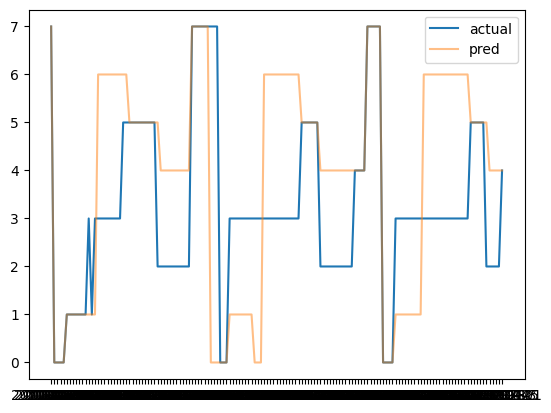

In [113]:
plt.plot(rf_df['time'],rf_df['y_test'],label='actual')
plt.plot(rf_df['time'],rf_df['y_pred'],alpha=0.5,label='pred')
plt.legend()
plt.show()

In [ ]:
model_info = GridSearchCV(estimator=model_rf,
                    param_grid = hyperparams_rf,
                    cv=5)
model_info.fit(X_train,y_train)
model_n = model_info.best_estimator_
y_pred = model_n.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.38620689655172413
혼동행렬:
 [[11  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 25  2  0  0]
 [ 3 19  0  0  0  0 35  0]
 [ 0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0 20  2  0]
 [ 0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0 12]]
분류보고서
               precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.30      1.00      0.46         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.17      1.00      0.29         5
           5       0.91      0.91      0.91        22
           6       0.00      0.00      0.00         0
           7       1.00      0.80      0.89        15

    accuracy                           0.39       145
   macro avg       0.38      0.59      0.42       145
weighted avg       0.31      0.39      0.32       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [116]:
from tensorflow import keras

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten,Dropout,SimpleRNN,LSTM, MaxPooling1D,AveragePooling1D,GlobalAvgPool1D

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=5,
    verbose=1,
    mode='auto' )

In [136]:
y_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [125]:
X_train_reshape = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_test_reshape = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])

In [126]:
Fnn = Sequential()
Fnn.add(Dense(128,activation='relu',input_dim=(X_train_reshape.shape[1])))
Fnn.add(Dense(64,activation='relu'))
Fnn.add(Dense(32,activation='relu'))
Fnn.add(Dense(y_train.shape[1],activation='softmax'))
Fnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
Fnn.summary()

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,465 (119.00 KB)

 Trainable params: 30,465 (119.00 KB)

 Non-trainable params: 0 (0.00 B)

In [299]:
train_x_cnn.shape

(540, 10, 512)

In [440]:
Fnn_history = Fnn.fit(X_train_reshape,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1887 - loss: 2.1647 - val_accuracy: 0.1379 - val_loss: 2.0636
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2689 - loss: 1.9727 - val_accuracy: 0.1379 - val_loss: 1.8788
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3184 - loss: 1.7223 - val_accuracy: 0.2586 - val_loss: 1.5989
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4561 - loss: 1.4722 - val_accuracy: 0.5690 - val_loss: 1.3158
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5644 - loss: 1.2365 - val_accuracy: 0.5345 - val_loss: 1.1844
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6369 - loss: 1.1285 - val_accuracy: 0.3448 - val_loss: 1.0927
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6309 - loss: 0.9873 - val_accuracy: 0.4483 - val_loss: 1.0103
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6879 - loss: 0.9001 - val_accuracy: 0.5345 - 

In [441]:
y_pred = Fnn.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print('-----------FNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
-----------FNN-----------
정확도: 0.27972027972027974
혼동행렬:
 [[ 4  4  0  0  0  0  0  2]
 [ 1  7  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  1]
 [ 0 22  0  0  0  3 32  0]
 [ 0  0  0  0  1  0  0  4]
 [ 0  0  0  0  2 16  4  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0 12]]
분류보고서
               precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.21      0.88      0.34         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.03      0.20      0.06         5
           5       0.84      0.73      0.78        22
           6       0.00      0.00      0.00         0
           7       0.63      0.86      0.73        14

    accuracy                           0.28       143
   macro avg       0.31      0.38      0.30       143
weighted avg       0.26      0.28      0.25       143



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [43]:
y_train.shape

(572, 635019)

In [140]:
Cnn = Sequential()
Cnn.add(Conv1D(64,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn.add(MaxPooling1D(2))
Cnn.add(Conv1D(128,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn.add(MaxPooling1D(2))
Cnn.add(Flatten())
Cnn.add(Dense(32,activation = 'relu'))
Cnn.add(Dense(16,activation = 'relu'))
Cnn.add(Dense(1))

In [175]:
# model=Sequential([
#             Conv1D(64,3, activation='relu', input_shape=(self.window_size,4)),
#             Conv1D(32,3,activation='relu'),
#             Flatten(),
#             Dense(50,activation='relu'),
#             Dense(1)
#         ])
#         model.compile(optimizer='adam',loss='mse')

In [141]:
Cnn.compile(optimizer='adam', loss='mse')
Cnn.summary()
Cnn_history = Cnn.fit(X_train,y_train,epochs=100,validation_split=0.2,callbacks=[early_stopping])

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 11, 64)         │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 4, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,009 (105.50 KB)

 Trainable params: 27,009 (105.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.5168 - val_loss: 1.4739
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5110 - val_loss: 1.5968
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4011 - val_loss: 1.5399
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3799 - val_loss: 1.5096
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3945 - val_loss: 1.5608
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3969 - val_loss: 1.5234
Epoch 6: early stopping


In [138]:
cnn_y_test_inv .shape

(286, 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


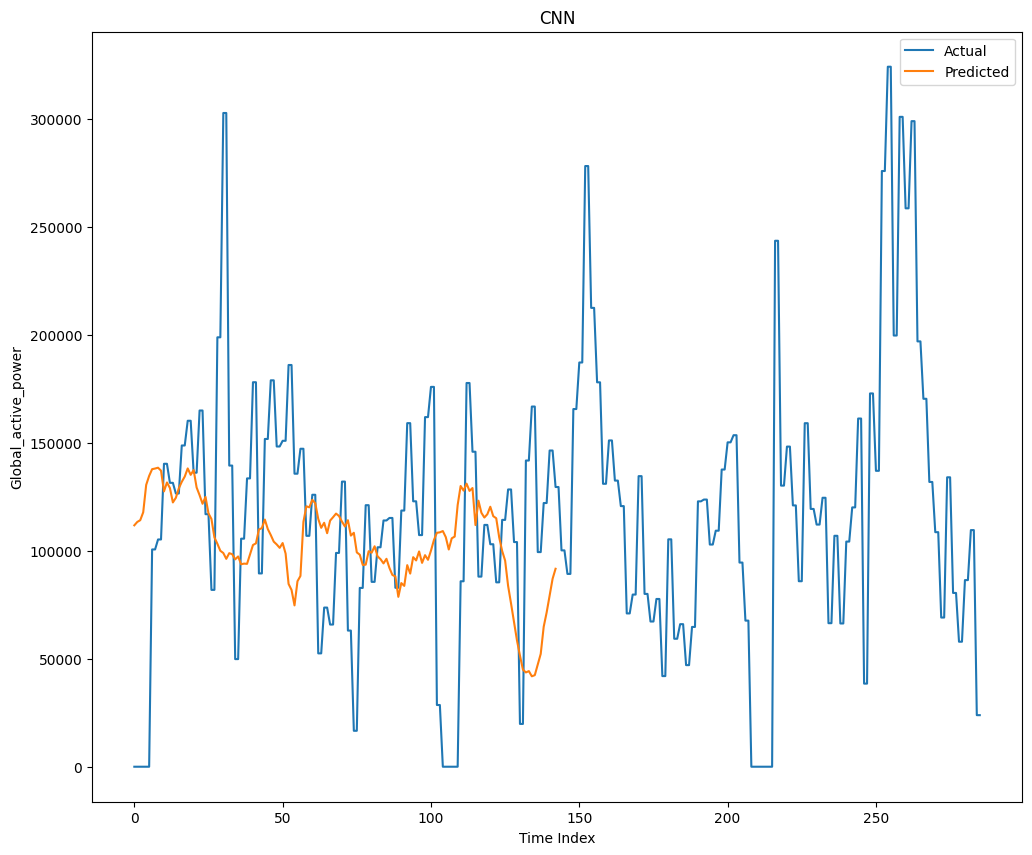

In [142]:
cnn_y_pred_scaled = Cnn.predict(X_test)
cnn_y_pred_inv = y_scaler.inverse_transform(cnn_y_pred_scaled)
cnn_y_test_inv = y_scaler.inverse_transform(y_test)
plt.figure(figsize=(12, 10))
plt.plot(cnn_y_test_inv, label='Actual')
plt.plot(cnn_y_pred_inv, label='Predicted')
plt.legend()
plt.title('CNN')
plt.xlabel('Time Index')
plt.ylabel('Global_active_power')
plt.show()

In [469]:
Rnn = Sequential()
Rnn.add(SimpleRNN(128, activation='tanh', input_shape=(train_x_cnn.shape[1],train_x_cnn.shape[2]),return_sequences=True))
Rnn.add(SimpleRNN(64, return_sequences=True,activation='tanh'))
Rnn.add(SimpleRNN(32,activation='tanh'))
Rnn.add(Dense(units=16, activation='relu'))
Rnn.add(Dense(y_train.shape[1],activation='softmax'))
Rnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [428]:
X_train.shape

(572, 12, 26)

In [358]:
print(Rnn.summary())

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_45 (SimpleRNN)       │ (None, 10, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_46 (SimpleRNN)       │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_47 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,185 (383.54 KB)

 Trainable params: 98,185 (383.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [349]:
X_train.shape

(540, 52, 47)

In [470]:
Rnn_history = Rnn.fit(train_x_cnn,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.2043 - loss: 1.9769 - val_accuracy: 0.5172 - val_loss: 1.4484
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5872 - loss: 1.3940 - val_accuracy: 0.8621 - val_loss: 1.0456
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8060 - loss: 1.0613 - val_accuracy: 0.6379 - val_loss: 0.9770
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7931 - loss: 0.7850 - val_accuracy: 0.7931 - val_loss: 0.7471
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8300 - loss: 0.6483 - val_accuracy: 0.7069 - val_loss: 0.8290
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8839 - loss: 0.5209 - val_accuracy: 0.8621 - val_loss: 0.5700
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8816 - loss: 0.4284 - val_accuracy: 0.7759 - val_loss: 0.6796
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9004 - loss: 0.3658 - val_accuracy: 0.7414 -

In [471]:
y_pred = Rnn.predict(test_x_cnn)
y_pred = np.argmax(y_pred,axis=1)
print('-----------RNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
-----------RNN-----------
정확도: 0.3006993006993007
혼동행렬:
 [[ 5  2  0  0  1  0  0  2]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 25  2  0  0]
 [ 0 27  0  0  0  8 22  0]
 [ 0  0  0  0  4  0  0  1]
 [ 0  0  0  0  0 19  3  0]
 [ 0  0  0  0  0  0  0  0]
 [ 1  0  0  0  6  0  0  7]]
분류보고서
               precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.22      1.00      0.36         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.11      0.80      0.20         5
           5       0.66      0.86      0.75        22
           6       0.00      0.00      0.00         0
           7       0.70      0.50      0.58        14

    accuracy                           0.30       143
   macro avg       0.31      0.46      0.31       143
weighted avg       0.24      0.30      0.24       143



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [179]:
X_train.shape[1]

4

In [183]:
help(LSTM)

Help on class LSTM in module keras.src.layers.rnn.lstm:

class LSTM(keras.src.layers.rnn.rnn.RNN)
 |  LSTM(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, seed=None, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, use_cudnn='auto', **kwargs)
 |  
 |  Long Short-Term Memory layer - Hochreiter 1997.
 |  
 |  Based on available runtime hardware and constraints, this layer
 |  will choose different implementations (cuDNN-based or backend-native)
 |  to maximize the performance. If a GPU is available and all
 |  the arguments to the layer meet the requirement of the cuDNN kernel
 |  (see below

In [472]:
Lstm = Sequential()
Lstm.add(LSTM(units=64, activation='tanh', return_sequences=True,input_shape=(train_x_cnn.shape[1],train_x_cnn.shape[2])))

Lstm.add(LSTM(units=32,activation='tanh',return_sequences=True))

Lstm.add(LSTM(units=16))

#출력층
Lstm.add(Dense(9, activation='softmax'))

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#print(X_train.shape)

(578, 4, 47)


In [473]:
Lstm.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
Lstm.summary()
Lstm_history = Lstm.fit(train_x_cnn,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 5, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 5, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,729 (190.35 KB)

 Trainable params: 48,729 (190.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.2400 - loss: 2.0985 - val_accuracy: 0.2586 - val_loss: 1.8971
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4435 - loss: 1.7703 - val_accuracy: 0.4310 - val_loss: 1.4980
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6477 - loss: 1.2885 - val_accuracy: 0.6034 - val_loss: 1.1229
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7176 - loss: 0.9288 - val_accuracy: 0.6379 - val_loss: 0.9404
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8112 - loss: 0.7776 - val_accuracy: 0.7759 - val_loss: 0.7717
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8569 - loss: 0.6354 - val_accuracy: 0.8103 - val_loss: 0.7843
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8333 - loss: 0.5557 - val_accuracy: 0.8103 - val_loss: 0.7687
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8359 - loss: 0.5385 - val_accuracy: 0.

In [474]:
y_pred = Lstm.predict(test_x_cnn)
y_pred = np.argmax(y_pred,axis=1)
print('-----------LSTM-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
-----------LSTM-----------
정확도: 0.2937062937062937
혼동행렬:
 [[ 7  2  0  0  0  0  0  1]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 24  3  0  0]
 [ 0 23  0  0  4  3 27  0]
 [ 0  0  0  0  4  0  0  1]
 [ 0  0  0  0  0 18  4  0]
 [ 0  0  0  0  0  0  0  0]
 [ 3  0  0  0  6  0  0  5]]
분류보고서
               precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.24      1.00      0.39         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.11      0.80      0.19         5
           5       0.75      0.82      0.78        22
           6       0.00      0.00      0.00         0
           7       0.71      0.36      0.48        14

    accuracy                           0.29       143
   macro avg       0.31      0.46      0.32       143
weighted avg       0.25      0.29      0.24       143



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [ ]:
eval_df = pd.DataFrame({'Model': ['FNN', 'CNN', 'RNN', 'LSTM'],
                        'Accuracy': [accuracy_score(y_test_raw, np.argmax(Fnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Cnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Rnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Lstm.predict(X_test),aixs=1))]})

In [210]:
X_train.shape[1]

4

In [467]:
## CNN 특징 추출
Cnn_F =Sequential()
Cnn_F.add(Conv1D(32,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn_F.add(Conv1D(64,2, activation='relu'))
Cnn_F.add(MaxPooling1D(2))


Cnn_F.summary()

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_69 (Conv1D)              │ (None, 11, 32)         │         1,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_70 (Conv1D)              │ (None, 10, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 5, 64)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,856 (22.88 KB)

 Trainable params: 5,856 (22.88 KB)

 Non-trainable params: 0 (0.00 B)

In [468]:
train_x_cnn = Cnn_F.predict(X_train)
test_x_cnn = Cnn_F.predict(X_test)

train_x_cnn.shape

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


(572, 5, 64)